# Kedi Ve Köpekler

İlk önce drive'ımızı ekliyoruz...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GAIH/2

Gerekli dosyaların yüklenmesi burada yapılıyor. Bizde sadece split-folders yüklü olmadığı için onu kuracağım.

In [ ]:
!pip install split-folders

Verinin içinde Thumbs.db diye bir dosya var. Bu dosyayı train-test-val için ayırmadan önce silmemiz gerekiyor. Eğer silinmezse modeli eğitirken bu dosyayı da eğitime alıp hata verecektir...

In [1]:
import os
os.remove('PetImages/Cat/Thumbs.db')
os.remove('PetImages/Dog/Thumbs.db')

Verilen sınıflar train-test-val için ayrılmadıysa ben splitfolders'ı kullanıp bunların ayrılmasını sağlıyorum. En sondaki oranlar train-test-val şeklindedir.

In [1]:
import splitfolders

splitfolders.ratio('PetImages/','output',seed=1337,ratio=(0.7,0.2,0.1))

Copying files: 25000 files [01:33, 268.78 files/s]


Veri sıkıntılı ve eğitim sırasında hata verdiği için sıkıntılı fotoğrafları anlamak için bir kod parçası yazdık.

In [6]:
import glob
from PIL import Image
for i in glob.glob('output/***/**/*.jpg'):
    try:
        Image.open(i)
    except:
        print(i)

output\train\Cat\666.jpg
output\train\Dog\11702.jpg


In [8]:
os.remove('output/train/Cat/666.jpg')
os.remove('output/train/Dog/11702.jpg')

Gerekli kütüphaneleri importlayıp GPU'muz aktif mi diye bakıyoruz...

In [2]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


Train-test-val ayırmasını kendimiz yaptığımız için ImageDataGenerator'daki validation-split'e tekrardan veri ayırmıyoruz.

In [3]:
image_generator = ImageDataGenerator(rescale=1/255) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='output/train/',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='output/val/',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 class_mode='categorical')

test_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='output/test/',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 class_mode='categorical')

Found 17500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Verilerimizin sayılarını üstte görebiliriz. Alt kısımda ise bunların resimleri vardır...

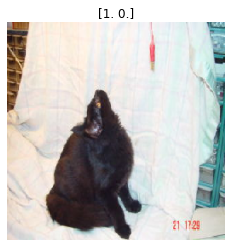

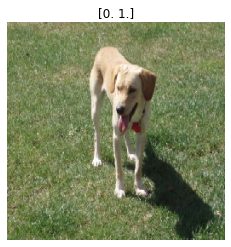

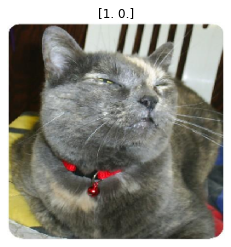

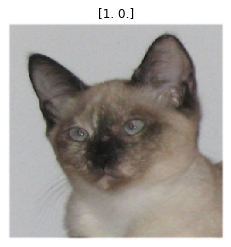

In [4]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()


Modelimizi VGG19 olarak belirledik. Boyutlar üsttekilerle eşit olmalıdır. Prediction kısmındaki Dense nöronumuz da verilen sınıfla eşit olmalıdır. Burada değerimiz 2'dir.

In [12]:
vgg = VGG19(input_shape=(256,256,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

Compile ederken loss fonksiyonumuz sınıf sayımızla eşit olmalıdır. Burada 1-0 kullanacağımız için BinaryCrossEntropy uygundur.

Metrik belirlerken EarlyStopping kullanacağım için monitör edeceğim değişkenle uygun olmalıdır. Bazen hata verebiliyor...

In [13]:
modelvgg.compile(
  loss=tensorflow.losses.BinaryCrossentropy(),
  optimizer='adam',
  metrics=['accuracy']
)
callback = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4,
                                            restore_best_weights=True)]


modelvgg.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callback)

Epoch 1/30
2188/2188 [==============================] - 190s 87ms/step - loss: 0.3161 - accuracy: 0.8804 - val_loss: 0.2771 - val_accuracy: 0.9050
Epoch 2/30
2188/2188 [==============================] - 188s 86ms/step - loss: 0.2049 - accuracy: 0.9264 - val_loss: 0.3151 - val_accuracy: 0.9016
Epoch 3/30
2188/2188 [==============================] - 190s 87ms/step - loss: 0.1706 - accuracy: 0.9418 - val_loss: 0.2693 - val_accuracy: 0.9214
Epoch 4/30
2188/2188 [==============================] - 189s 87ms/step - loss: 0.1276 - accuracy: 0.9552 - val_loss: 0.3451 - val_accuracy: 0.9126
Epoch 5/30
2188/2188 [==============================] - 190s 87ms/step - loss: 0.0993 - accuracy: 0.9646 - val_loss: 0.3385 - val_accuracy: 0.9144
Epoch 6/30
2188/2188 [==============================] - 190s 87ms/step - loss: 0.0813 - accuracy: 0.9713 - val_loss: 0.3973 - val_accuracy: 0.9060
Epoch 7/30
2188/2188 [==============================] - 190s 87ms/step - loss: 0.0800 - accuracy: 0.9732 - val_loss: 0

In [15]:
loss, accuracy = modelvgg.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

313/313 [==============================] - 19s 61ms/step - loss: 0.2531 - accuracy: 0.9292
Loss:  0.2531254291534424
Accuracy:  0.9291999936103821
